# Introduction
## What is mean reversion?
A mean reversion algorithm is a quantitative trading strategy based on the idea that asset prices and returns tend to move back towards their historical average or mean over time. When prices deviate significantly from this average, the algorithm identifies potential buy or sell opportunities, anticipating that prices will revert to the mean.

## Aim

The aim with this project is to develop a successful mean reversion algorithm which beats, or performs similarly, to the S&P 500 index which annually currently returns on average 10.33% (nominal). Development will take an iterative approach, refining previous strategies, datasets and parameters to improve the results yielded from the previous iteration

In [192]:
import yfinance as yf
from curl_cffi import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [193]:
session = requests.Session(impersonate="chrome") # To fix yfinance rate limitter bug
ticker = yf.Ticker("MSFT",session=session)

# Data Cleansing

In [194]:
# msft_historical_data = ticker.history(start='2000-01-01', end='2020-12-01', interval='1d').reset_index()


In [195]:
msft_historical_data = pd.read_csv("msft_00-20.csv")
msft_historical_data = msft_historical_data.drop(columns=["Open","High","Low","Dividends","Stock Splits"]) # Remove unnecessary Columns
msft_historical_data.dropna()

msft_historical_data["Date"] = pd.to_datetime(msft_historical_data["Date"],utc=True)

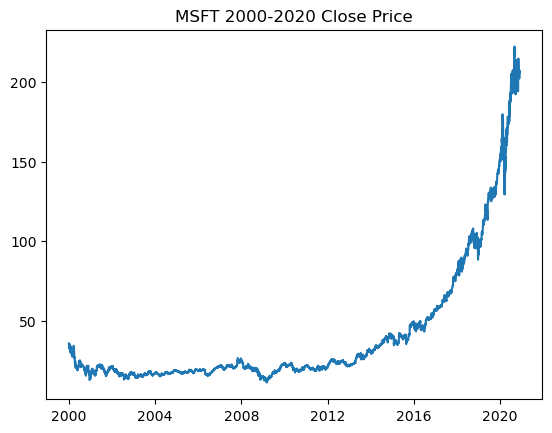

In [196]:
plt.plot(msft_historical_data["Date"],msft_historical_data["Close"])
plt.title("MSFT 2000-2020 Close Price")
plt.show()

# Mean Reversion Algorithm

In [197]:
# Create simple moving average column (2 week)
msft_historical_data["SMA"] = (msft_historical_data["Close"].rolling(14).sum()) / 14
msft_historical_data.dropna()

,Date,Close,Volume,SMA
13,2000-01-21 05:00:00+00:00,31.799646,68416200,33.802869
14,2000-01-24 05:00:00+00:00,31.033401,63597600,33.467632
15,2000-01-25 05:00:00+00:00,31.512310,59823200,33.252807
16,2000-01-26 05:00:00+00:00,30.458708,49365000,32.936726
17,2000-01-27 05:00:00+00:00,30.267136,63654800,32.690429
...,...,...,...,...
5257,2020-11-23 05:00:00+00:00,202.318283,25683500,207.117443
5258,2020-11-24 05:00:00+00:00,205.929214,33979700,206.982293
5259,2020-11-25 05:00:00+00:00,205.938812,21012900,206.374488
5260,2020-11-27 05:00:00+00:00,207.248428,14512200,205.830729


In [198]:
# Create standard deviation column over 2 week
msft_historical_data["Std_deviation"] = msft_historical_data["Close"].rolling(14).std()

In [199]:
msft_historical_data["Buy/Sell"] = np.where(msft_historical_data["Close"] > msft_historical_data["SMA"] + (msft_historical_data["Std_deviation"] * 2),"Sell",
                                            np.where(msft_historical_data["Close"] < msft_historical_data["SMA"] - (msft_historical_data["Std_deviation"] * 2),"Buy","Neither" ))
msft_historical_data = msft_historical_data.dropna()

In [200]:
# msft_historical_data_reversed = msft_historical_data[::-1] # Reverse to find the best buy/Sell price in future

# Returns

In [201]:
def calculateGain(row, df:pd.DataFrame):
    indexesOfNextFiveDays = row.name + 5 # row.name = row's index
    if indexesOfNextFiveDays < len(df):
        prices = df.iloc[row.name:indexesOfNextFiveDays]

        if row["Buy/Sell"] == "Buy":
            bestPrice = np.max(prices["Close"])
            exit = ((bestPrice - row["Close"]) / row["Close"]) * 100
            if exit < 0:
                return exit
            else:
                return exit
            
        elif row["Buy/Sell"] == "Sell":
            bestPrice = np.min(prices["Close"])
            exit = ((bestPrice - row["Close"]) / row["Close"]) * 100
            if exit < 0:
                return exit
            else:
                return exit
            
        else:
            return 0
        
    else:
        return None

In [202]:
msft_historical_data["Gain/Loss"] = msft_historical_data.apply(calculateGain, axis=1, args=(msft_historical_data,)) # Trailing comma makes it a tuple - required

In [203]:
display(msft_historical_data)

,Date,Close,Volume,SMA,Std_deviation,Buy/Sell,Gain/Loss
13,2000-01-21 05:00:00+00:00,31.799646,68416200,33.802869,1.173417,Neither,0.0
14,2000-01-24 05:00:00+00:00,31.033401,63597600,33.467632,1.249467,Neither,0.0
15,2000-01-25 05:00:00+00:00,31.512310,59823200,33.252807,1.311640,Neither,0.0
16,2000-01-26 05:00:00+00:00,30.458708,49365000,32.936726,1.417289,Neither,0.0
17,2000-01-27 05:00:00+00:00,30.267136,63654800,32.690429,1.563637,Neither,0.0
...,...,...,...,...,...,...,...
5257,2020-11-23 05:00:00+00:00,202.318283,25683500,207.117443,4.030430,Neither,NaN
5258,2020-11-24 05:00:00+00:00,205.929214,33979700,206.982293,4.036731,Neither,NaN
5259,2020-11-25 05:00:00+00:00,205.938812,21012900,206.374488,3.419585,Neither,NaN
5260,2020-11-27 05:00:00+00:00,207.248428,14512200,205.830729,2.427706,Neither,NaN


In [204]:
msft_historical_data[msft_historical_data["Buy/Sell"] != "Neither"]

,Date,Close,Volume,SMA,Std_deviation,Buy/Sell,Gain/Loss
46,2000-03-09 05:00:00+00:00,30.650269,88198800,28.668950,0.847914,Sell,-9.125012
47,2000-03-10 05:00:00+00:00,30.956766,85589000,28.798940,1.042372,Sell,-12.314349
56,2000-03-23 05:00:00+00:00,34.289978,148224000,30.180934,1.620722,Sell,-33.743010
57,2000-03-24 05:00:00+00:00,34.232525,112196800,30.642057,1.793284,Sell,-33.631810
77,2000-04-24 04:00:00+00:00,20.420746,313645800,24.813037,1.911503,Buy,4.315205
...,...,...,...,...,...,...,...
5196,2020-08-27 04:00:00+00:00,217.607819,57602200,203.869862,5.814981,Sell,-11.558840
5197,2020-08-28 04:00:00+00:00,219.845505,26292900,205.321587,7.051397,Sell,-12.459033
5227,2020-10-12 04:00:00+00:00,212.632919,40461400,201.079985,4.937389,Sell,-8.613372
5228,2020-10-13 04:00:00+00:00,214.035126,28950800,202.607711,5.413348,Sell,-9.212073


In [205]:
totalReturn = msft_historical_data["Gain/Loss"].sum()
print("Total Return: ", totalReturn,"%")

Total Return:  125.45123433056568 %


# Visualise Returns

In [206]:
msft_historical_data["Cumulative Returns"] = msft_historical_data["Gain/Loss"].cumsum()

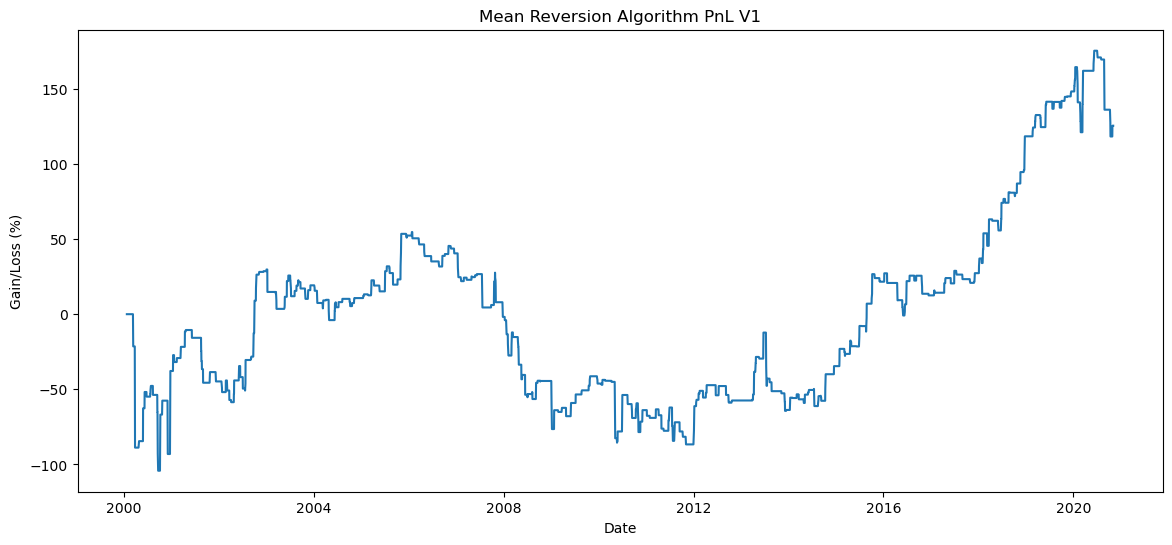

In [207]:
plt.figure(figsize=(14,6))
plt.plot(msft_historical_data["Date"],msft_historical_data["Cumulative Returns"])
plt.ylabel("Gain/Loss (%)")
plt.xlabel("Date")
plt.title("Mean Reversion Algorithm PnL V1")
plt.show()

## YoY Returns

In [208]:
first_recorded_year = msft_historical_data["Date"].dt.year.min()
most_recent_year = msft_historical_data["Date"].dt.year.max()

current_year = first_recorded_year
while (current_year <= most_recent_year):
    current_year_data = msft_historical_data[msft_historical_data["Date"].dt.year == current_year]
    num_trades_placed = current_year_data[current_year_data["Buy/Sell"] != "Neither"].shape[0]

    print ("Year: ",current_year)
    print("Annual Return", current_year_data["Gain/Loss"].sum())
    print("# of Trades Placed: ", num_trades_placed)
    print("\n")

    current_year += 1

print("\nAverage YoY Return: ", totalReturn / 20)

Year:  2000
Annual Return -37.8083235391008
# of Trades Placed:  24


Year:  2001
Annual Return -6.949152647043313
# of Trades Placed:  14


Year:  2002
Annual Return 74.50016779149765
# of Trades Placed:  26


Year:  2003
Annual Return -10.540653240847918
# of Trades Placed:  23


Year:  2004
Annual Return -8.484199922120796
# of Trades Placed:  24


Year:  2005
Annual Return 41.60098006692114
# of Trades Placed:  30


Year:  2006
Annual Return -11.830597455753674
# of Trades Placed:  18


Year:  2007
Annual Return -42.29258798819014
# of Trades Placed:  23


Year:  2008
Annual Return -42.65138319417824
# of Trades Placed:  26


Year:  2009
Annual Return -1.7279900037621339
# of Trades Placed:  16


Year:  2010
Annual Return -17.681406686686994
# of Trades Placed:  28


Year:  2011
Annual Return -22.80297262676937
# of Trades Placed:  19


Year:  2012
Annual Return 29.227283822044832
# of Trades Placed:  20


Year:  2013
Annual Return -6.3077633436871
# of Trades Placed:  20


Year:  

# Iteration 1: Results summary
- The mean reversion algo was applied to Microsoft (MSFT) from 2000-2020.
- The total return across that 20-year period was 125.45% with a 6.27% average yearly return
- On average, 22 trades were placed per year
- 2018 was the most profitable year with a 91.1% return
- 2007 was the least profitable year with a loss of -42.7% - potentially partially attributed to the GFC


# Mean Reversion Algorithm - v2
- In the first iteration, an average of only 22 trades were placed per year — less than two trades per month. This low trade frequency may have contributed to the large fluctuations in annual returns. In the second iteration, we will adjust the SMA window and the standard deviation multiplier to lower the threshold for making trades and increase trading activity.

In [209]:
msft_historical_data["Buy/Sell"] = np.where(msft_historical_data["Close"] > msft_historical_data["SMA"] + (msft_historical_data["Std_deviation"] * 1.1),"Sell",
                                            np.where(msft_historical_data["Close"] < msft_historical_data["SMA"] - (msft_historical_data["Std_deviation"] * 1.1),"Buy","Neither" ))
msft_historical_data = msft_historical_data.dropna()

In [210]:
# Recalculate gains and losses
msft_historical_data["Gain/Loss"] = msft_historical_data.apply(calculateGain, axis=1, args=(msft_historical_data,)) # Trailing comma makes it a tuple - required

# Recalculate total returns
totalReturn = msft_historical_data["Gain/Loss"].sum()
print("Total Return: ", totalReturn,"%")

# Recalculate cumulative returns
msft_historical_data["Cumulative Returns"] = msft_historical_data["Gain/Loss"].cumsum()

Total Return:  1877.008558697564 %


In [211]:
first_recorded_year = msft_historical_data["Date"].dt.year.min()
most_recent_year = msft_historical_data["Date"].dt.year.max()

current_year = first_recorded_year
while (current_year <= most_recent_year):
    current_year_data = msft_historical_data[msft_historical_data["Date"].dt.year == current_year]
    num_trades_placed = current_year_data[current_year_data["Buy/Sell"] != "Neither"].shape[0]

    print ("Year: ",current_year)
    print("Annual Return", current_year_data["Gain/Loss"].sum())
    print("# of Trades Placed: ", num_trades_placed)
    print("\n")

    current_year += 1

print("\nAverage YoY Return: ", totalReturn / 20)

Year:  2000
Annual Return -77.62601441126779
# of Trades Placed:  124


Year:  2001
Annual Return 283.4369651721447
# of Trades Placed:  114


Year:  2002
Annual Return 4.825238657154571
# of Trades Placed:  122


Year:  2003
Annual Return -8.976451607958317
# of Trades Placed:  120


Year:  2004
Annual Return 9.158453728422195
# of Trades Placed:  111


Year:  2005
Annual Return 100.12196719692817
# of Trades Placed:  140


Year:  2006
Annual Return 114.22830423840517
# of Trades Placed:  122


Year:  2007
Annual Return 63.315798291521695
# of Trades Placed:  123


Year:  2008
Annual Return -79.0532150743839
# of Trades Placed:  95


Year:  2009
Annual Return 311.451102151953
# of Trades Placed:  121


Year:  2010
Annual Return 24.230036632624234
# of Trades Placed:  135


Year:  2011
Annual Return 66.04995035680135
# of Trades Placed:  113


Year:  2012
Annual Return 35.855300527899615
# of Trades Placed:  106


Year:  2013
Annual Return 127.85749765485757
# of Trades Placed:  109




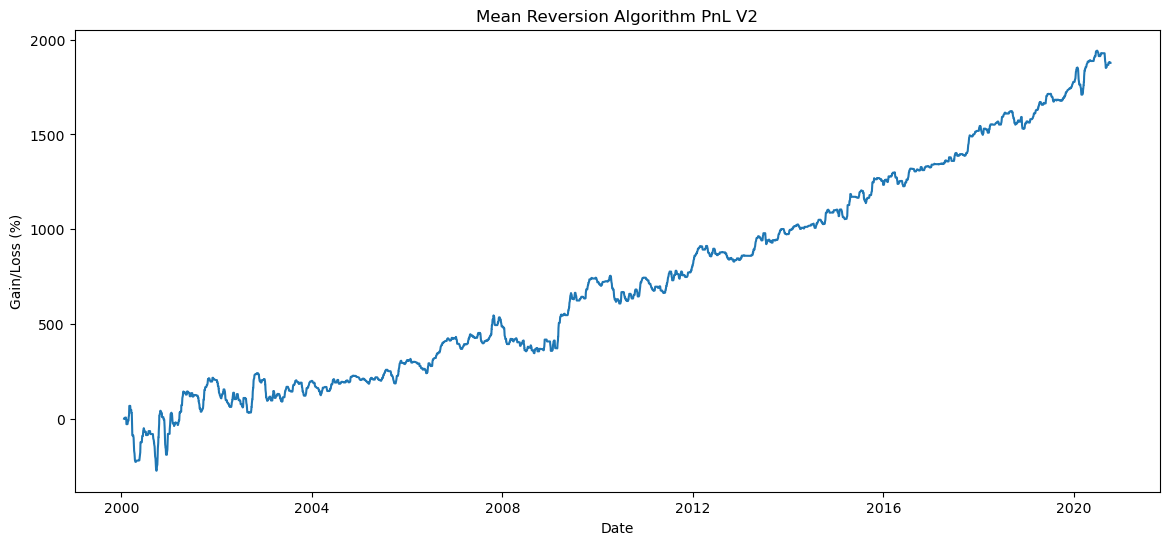

In [212]:
plt.figure(figsize=(14,6))
plt.plot(msft_historical_data["Date"],msft_historical_data["Cumulative Returns"])
plt.ylabel("Gain/Loss (%)")
plt.xlabel("Date")
plt.title("Mean Reversion Algorithm PnL V2")
plt.show()

# Version 2: Results Summary
- The multiplier applied to the standard deviation value was lowered significantly from 2 to 1.1
- The total return across the same time period was now 1877% (up from 125.45%) with a 93.85% average yearly return (up from 6.27%)
- On average, 105 trades were placed per year
- 2001 was the most profitable year with a 283.4% return
- 2008 was the least profitable year with a loss of -79.05%.